# Sea Ice Validation for ACCESS-OM2_01
TODO: compare thickness with cryosat data

Fields in CICE output .nc files have ni, nj coords without dimensions which makes things awkward...
TODO: give CICE fields the dimensions from MOM grid file?

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from glob import glob
import os,sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import xarray as xr
import netCDF4 as nc
from tqdm import tqdm_notebook
from mpl_toolkits.basemap import Basemap
from calendar import month_abbr
import cmocean as cm
import pandas as pd
import calendar
import copy
from datetime import datetime

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/156/aek156/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# cc.start_cluster()

In [3]:
figdir = ''
# NOSYNC = '/g/data/v45/aek156/figures/ACCESS-OM2-1-025-010deg-report/figures/ice_validation/NOSYNC/' # where to save figs we don't want to sync
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
font = {'size':13}
tick_font=12

In [5]:
# cc.build_index(careful=True)

In [6]:
use_cache = True

In [7]:
# define start and end dates for all runs
tstart = pd.to_datetime('1985', format='%Y')
tend = tstart + pd.DateOffset(years=15)

In [8]:
# define start and end dates for all runs
tstart = pd.to_datetime('1990', format='%Y')
tend = tstart + pd.DateOffset(years=10)

In [9]:
# define start and end dates for all runs
tstart = pd.to_datetime('1995', format='%Y')
tend = tstart + pd.DateOffset(years=20)

In [10]:
# use common start and end dates for all runs
tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [11]:
firstyear = pd.to_datetime(tstart).year  # assumes tstart is 1 January!
lastyear = pd.to_datetime(tend).year-1  # assumes tend is 1 January!
yearrange = str(firstyear)+'-'+str(lastyear)
print(yearrange)
print('tstart = ', tstart)
print('tend = ', tend)

1990-2014
tstart =  1990-01-01 00:00:00
tend =  2015-01-01 00:00:00


In [12]:
# Specify paths to observational data

# ObsDir = '/g/data1a/v45/aek156/data/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
# ObsDirExt = '/g/data1a/v45/aek156/data/NOAA/G02135'  # from http://nsidc.org/data/g02135
ObsDir = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02202_V3'  # from http://nsidc.org/data/G02202
ObsDirExt = '/g/data3/hh5/tmp/cosima/observations/NOAA/G02135'  # from http://nsidc.org/data/g02135
obsNHFileList = glob(os.path.join(ObsDir, 'north/monthly/*.nc'))
obsSHFileList = glob(os.path.join(ObsDir, 'south/monthly/*.nc'))
obsExtNHFileList = glob(os.path.join(ObsDirExt, 'north/monthly/data/*.csv'))
obsExtSHFileList = glob(os.path.join(ObsDirExt, 'south/monthly/data/*.csv'))
obsNHFileList.sort()
obsSHFileList.sort()
obsExtNHFileList.sort()
obsExtSHFileList.sort()

In [13]:
def loaddata(ekey):
    global vicen_m, aice_m, hi_m, vicen_m_monthly_mean, aice_m_monthly_mean, hi_m_monthly_mean, lon_t, lat_t, area_t, NLAT_half
    expt = exptdata.exptdict[ekey]['expt']
    exptdir = exptdata.exptdict[ekey]['exptdir']
    time_units = exptdata.exptdict[ekey]['time_units']
#     tmp = cc.get_nc_variable(expt, 'iceh.????-??.nc', 'vicen_m', time_units=time_units, 
#                              use_cache=use_cache)
#     print(tmp['time'].data[0])
#     print(tmp['time'].data[-1])

    vicen_m = cc.get_nc_variable(expt, 'iceh.????-??.nc', 'vicen_m', time_units=time_units, 
                             use_cache=use_cache, n=-500)
    aice_m = cc.get_nc_variable(expt, 'iceh.????-??.nc', 'aice_m', time_units=time_units, 
                             use_cache=use_cache, n=-500)
    hi_m = cc.get_nc_variable(expt, 'iceh.????-??.nc', 'hi_m', time_units=time_units, 
                             use_cache=use_cache, n=-500)
    
    vicen_m_monthly_mean = vicen_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    aice_m_monthly_mean = aice_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    hi_m_monthly_mean = hi_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)


    # get model grid data:
    # TODO: get these from CICE output file instead
    gridFileList = glob(os.path.join(exptdir, 'output*/ocean/ocean_grid.nc'))
    gridFileList.sort()
    ncFile = nc.Dataset(gridFileList[0],'r')
#     xt_ocean = ncFile.variables['xt_ocean'][...]
#     yt_ocean = ncFile.variables['yt_ocean'][...]
#     lon_t = ncFile.variables['geolon_t'][...]
#     lat_t = ncFile.variables['geolat_t'][...]
    area_t = ncFile.variables['area_t'][...]
    lon_t = exptdata.joinseams(ncFile.variables['geolon_t'][...], tripole_flip=True, lon=True)
    lat_t = exptdata.joinseams(ncFile.variables['geolat_t'][...], tripole_flip=True)
    
    NLAT_half = int(np.shape(area_t)[0]/2)
#     ht = ncFile.variables['ht'][...]
#     land_mask = np.copy(ht)
#     land_mask[np.where(ht>30)] = 0
#     land_mask[np.where(ht<=30)] = 1
    ncFile.close()


# Time series


## Time series of sea ice volume (by category), area and extent

`vicen_m(time, nc, nj, ni)`
		has units = "m",
so need to multiply by `area_t` to get volume.
`nc` is number of ice categories.

We use kcatbound=0, so lower bound of ice categories is 0, 0.64, 1.39, 2.47, 4.57m (HunkeLipscombTurnerJefferyElliott2015a-CICE5p1, table 2).

Much of the Arctic ice volume (not area) is >4.57m thick, including in the summer minimum.

In [14]:
def calcvol():
# WARNING - this can take several minutes
    global NH_ice_volume, SH_ice_volume
    volume = vicen_m*area_t # vicen_m(time, nc, nj, ni) has units = "m", so need to multiply by `area_t` to get volume.
    volume_zonalsum = volume.sum(axis=-1).compute()  # do this once for both NH & SH
    NH_ice_volume = volume_zonalsum.isel(nj=slice(NLAT_half,np.shape(area_t)[0])).sum(axis=-1)
    SH_ice_volume = volume_zonalsum.isel(nj=slice(0,NLAT_half)).sum(axis=-1)

In [15]:
def plotvol(v):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    for c in range(len(v['nc'])):
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+str(c+1))
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
#     total
#     plt.plot(v['time'],v.sum(axis=-1)/1e12, color='k', linewidth=1, label='Total')
#     plt.plot(v['time'][6:-5],
#              v.rolling(time=12, center=True).mean().sum(axis=-1)[6:-5]/1e12,  # 12-month rolling mean
#              color='k', linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)',font)

In [16]:
def plotvolcumul(v):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    v = v.cumsum(axis=-1)
    cats = list(range(len(v['nc'])))
    cats.reverse()  # so legend is in same order as plotted data
    for c in cats:
        plt.plot(v['time'],v.isel(nc=c)/1e12, color='C'+str(c), linewidth=1, label='Category '+'+'.join([str(f+1) for f in range(c+1)]))
        plt.plot(v['time'],
                 v.rolling(time=12, center=True).mean().isel(nc=c)/1e12, # 12-month rolling mean
                 color='C'+str(c), linewidth=2)
    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice volume (10$^{12}$ m$^3$)',font)

In [17]:
def plotvolNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotvol(NH_ice_volume)
    plt.title('Arctic ice volume, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotvol(SH_ice_volume)
    plt.title('Antarctic ice volume, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_volume_categories_'+ekey)

In [18]:
def plotvolcumulNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotvolcumul(NH_ice_volume)
    plt.title('Arctic ice volume, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotvolcumul(SH_ice_volume)
    plt.title('Antarctic ice volume, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_volume_categories_cumulative'+ekey)

## Seasonal cycle of sea ice extent and area
We adopt the usual definition of sea ice extent as the area in which sea ice concentration exceeds 15\%.

- obs in `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/north/monthly/data/*.csv` and  `/g/data3/hh5/tmp/cosima/observations/NOAA/G02135/south/monthly/data/*.csv`
- file names `N_mm_extent_v3.0.csv`, `S_mm_extent_v3.0.csv` where `mm` is month number
- first full year: 1979
- last full year: 2017
- missing extent data (-9999): Dec 1987, Jan 1988

CSV format:
```
year, mo,    data-type, region, extent,   area
1978, 12,      Goddard,      N,  13.67,  10.90
...
```


In [47]:
def loadObsExt(fnlist):
    """
    Return xarray DataSet of sea ice extent and area from NOAA/G02135 csv file list
    """
    df = pd.concat([pd.read_csv(f) for f in fnlist])  # read all csv files into a pandas DataFrame
    df.columns = df.columns.str.strip()  # remove leading/trailing whitespace from headers
    df['time'] = df.apply(lambda r: datetime(r['year'], r['mo'], 15), axis=1)  # make a date column (set day=15)
    df = df.drop(columns=['year', 'mo', 'data-type', 'region'])  # remove redundant columns
    num = df._get_numeric_data()
    num[num < 0] = np.nan  # replace bad data with NaN
    df = df.sort_values('time')
    ds = df.to_xarray()  # convert to xarray DataSet
    ds = ds.assign_coords(index=ds['time']).drop('time')  # set index values to time and remove time
    ds['extent'] = ds.extent.rename({'index': 'time'})  # rename extent coord to time
    ds['area'] = ds.area.rename({'index': 'time'})  # rename area coord to time
    ds = ds.drop('index')  # remove index
    ds = ds*1e12  # convert from M km^2 to m^2
    return ds

In [48]:
NH_obs = loadObsExt(obsExtNHFileList)
NH_clim_obs = NH_obs.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
# NH_extent_clim_obs = NH_climatology_obs.extent
SH_obs = loadObsExt(obsExtSHFileList)
SH_clim_obs = SH_obs.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
# SH_extent_clim_obs = SH_climatology_obs.extent

In [88]:
def calcarea():
    global NH_area, SH_area, NH_area_clim, SH_area_clim
    area = aice_m*area_t
    area_zonalsum = area.sum('ni').compute()  # do this once for both NH & SH
    NH_area = area_zonalsum[:,NLAT_half:].sum('nj')
    SH_area = area_zonalsum[:,:NLAT_half].sum('nj')
    NH_area_clim = NH_area.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    SH_area_clim = SH_area.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [99]:
def calcextent():
    global NH_extent, SH_extent, NH_extent_clim, SH_extent_clim
    extent = xr.where(aice_m > 0.15, area_t, 0)
    extent_zonalsum = extent.sum('ni').compute()  # do this once for both NH & SH
    NH_extent = extent_zonalsum[:,NLAT_half:].sum('nj')
    SH_extent = extent_zonalsum[:,:NLAT_half].sum('nj')
    NH_extent_clim = NH_extent.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    SH_extent_clim = SH_extent.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)

In [81]:
def plotarea(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice area (10$^{12}$ m$^2$)',font)

In [92]:
def plotareaNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotarea(NH_area, NH_obs.area)
    plt.title('Arctic ice area, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotarea(SH_area, SH_obs.area)
    plt.title('Antarctic ice area, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_area_'+ekey)

In [93]:
def plotextent(v, obs):
    v = v.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(v['time'],v/1e12, color='r', linewidth=1, label='Model')
    plt.plot(v['time'],
             v.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='r', linewidth=2)

    obs = obs.sel(time=slice(pd.to_datetime('1985', format='%Y'),tend))  # common time range for all plots
    plt.plot(obs['time'],obs/1e12, color='k', linewidth=1, label='Obs')
    plt.plot(obs['time'],
             obs.rolling(time=12, center=True).mean()/1e12, # 12-month rolling mean
             color='k', linewidth=2)

    plt.ylim(ymin=0)
    plt.xlabel('Year',font)
    plt.ylabel(r'Ice extent (10$^{12}$ m$^2$)',font)

In [96]:
def plotextentNHSH():
    plt.figure(1,(12,5))
    plt.clf()

    plt.subplot(2,1,1)
    plotextent(NH_extent, NH_obs.extent)
    plt.title('Arctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)

    plt.subplot(2,1,2)
    plotextent(SH_extent, SH_obs.extent)
    plt.title('Antarctic ice extent, '+exptdata.exptdict[ekey]['desc'],font)
    plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()

    savefigure('ice_extent_'+ekey)

## make timeseries plots for all resolutions

1deg
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_vicen_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/local.py:253: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


025deg
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_iceh.????-??.nc_vicen_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl
01deg
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_vicen_m_-500_None_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_aice_m_-500_None_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hi_m_-500_None_None_False.pkl


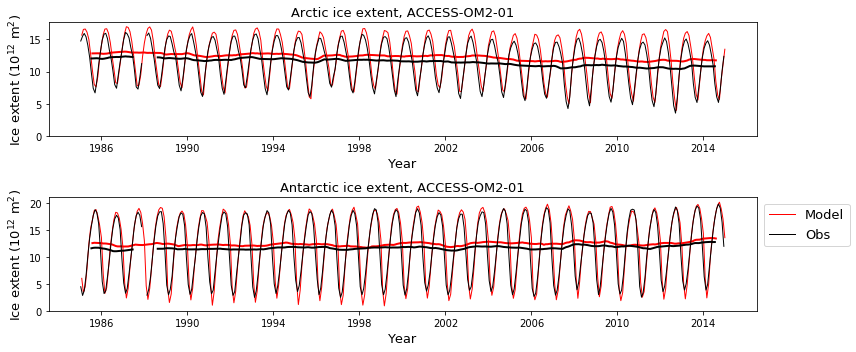

In [98]:
ice_data = copy.deepcopy(exptdata.exptdict)  # to store ice fields under the same keys as exptdata.exptdict
for ekey in ice_data.keys():
    print(ekey)
    loaddata(ekey)
    calcvol()
    calcarea()
    calcextent()
    ice_data[ekey]['NH_area'] = NH_area
    ice_data[ekey]['SH_area'] = SH_area
    ice_data[ekey]['NH_extent'] = NH_extent
    ice_data[ekey]['SH_extent'] = SH_extent    
#     plotvolNHSH()
#     plotvolcumulNHSH()
    plotareaNHSH()
    plotextentNHSH()
#     break

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


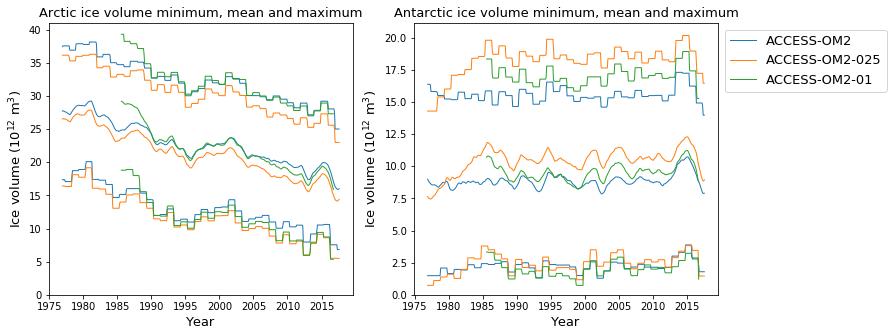

In [27]:
# 12-mo running mean minimum, mean and maximum of volume for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    totvol = ice_data[ekey]['NH_ice_volume'].sum(axis=-1)/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    totvol = ice_data[ekey]['SH_ice_volume'].sum(axis=-1)/1e12
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(totvol['time'][6:-5],totvol.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('Arctic ice volume minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice volume (10$^{12}$ m$^3$)',font)
plt.title('Antarctic ice volume minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
savefigure('ice_volume_min_mean_max_all')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


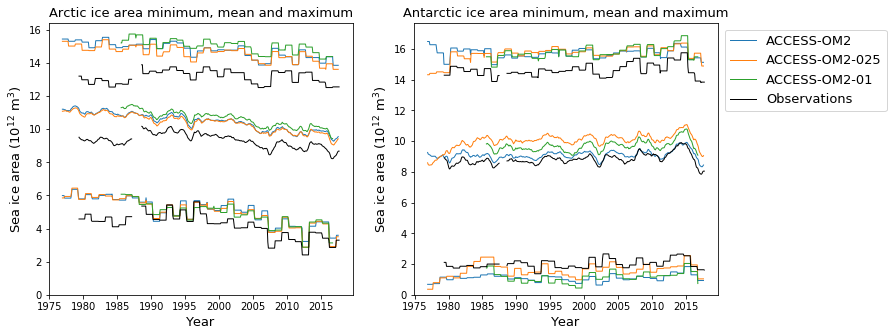

In [105]:
# 12-mo running mean minimum, mean and maximum of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_area']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_area']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
v = NH_obs.area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.area/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic ice area minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic ice area minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
savefigure('ice_area_min_mean_max_all')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


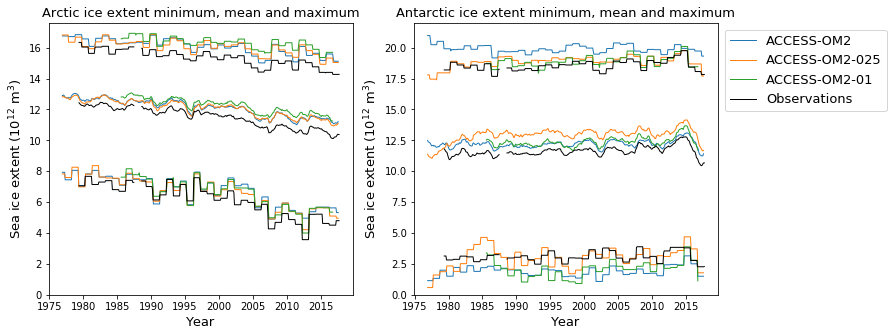

In [104]:
# 12-mo running mean minimum, mean and maximum of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(1,2,1)
    v = ice_data[ekey]['NH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

    plt.subplot(1,2,2)
    v = ice_data[ekey]['SH_extent']/1e12
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=1)
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='C'+str(c), linewidth=1)

plt.subplot(1,2,1)
v = NH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,2)
v = SH_obs.extent/1e12
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).max()[6:-5], color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).min()[6:-5], color='k', linewidth=1)

plt.subplot(1,2,1)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic ice extent minimum, mean and maximum',font)
plt.subplot(1,2,2)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Antarctic ice extent minimum, mean and maximum',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
savefigure('ice_extent_min_mean_max_all')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


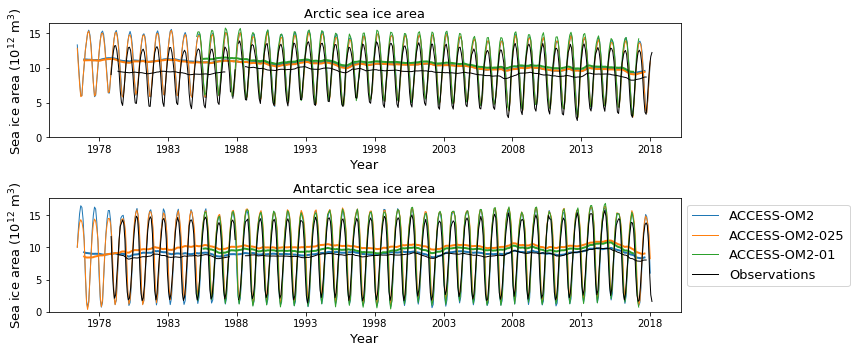

In [111]:
# 12-mo running mean and timeseries of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_area']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_area']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

plt.subplot(2,1,1)
v = NH_obs.area/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(2,1,2)
v = SH_obs.area/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice area',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice area',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_area_all')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


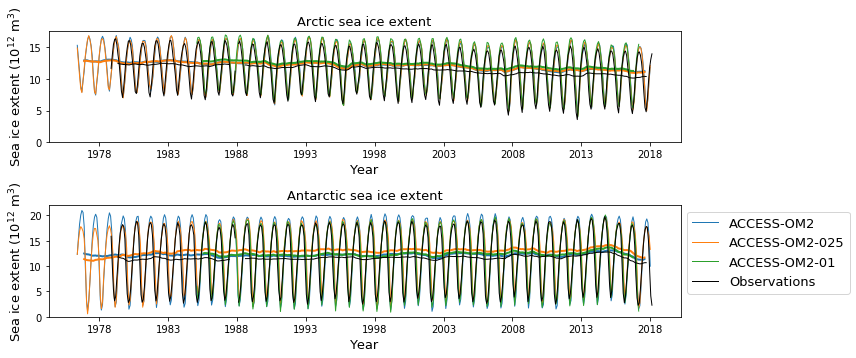

In [112]:
# 12-mo running mean and timeseries of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_extent']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_extent']/1e12
    plt.plot(v['time'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])
    plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='C'+str(c), linewidth=2)

plt.subplot(2,1,1)
v = NH_obs.extent/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(2,1,2)
v = SH_obs.extent/1e12
plt.plot(v['time'],v, color='k', linewidth=1, label='Observations')
plt.plot(v['time'][6:-5],v.rolling(time=12, center=True).mean()[6:-5], color='k', linewidth=1)

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice extent',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Year',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice extent',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_extent_all')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


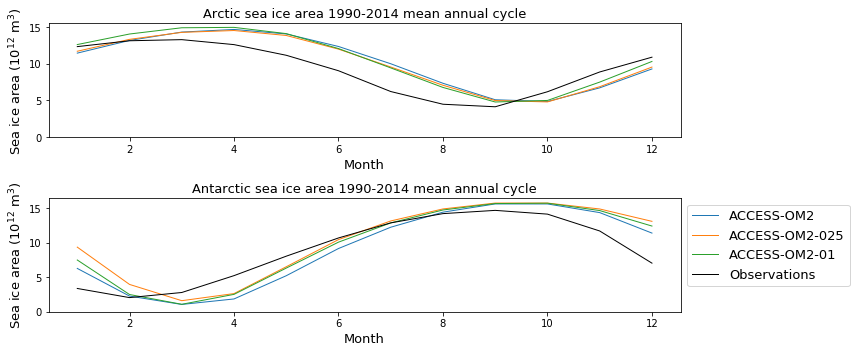

In [117]:
# seasonal cycle of area for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_area']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_area']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(2,1,1)
v = NH_obs.area/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,2)
v = SH_obs.area/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice area '+yearrange+' mean annual cycle',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice area (10$^{12}$ m$^2$)',font)
plt.title('Antarctic sea ice area '+yearrange+' mean annual cycle',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_area_seasonal_clim')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


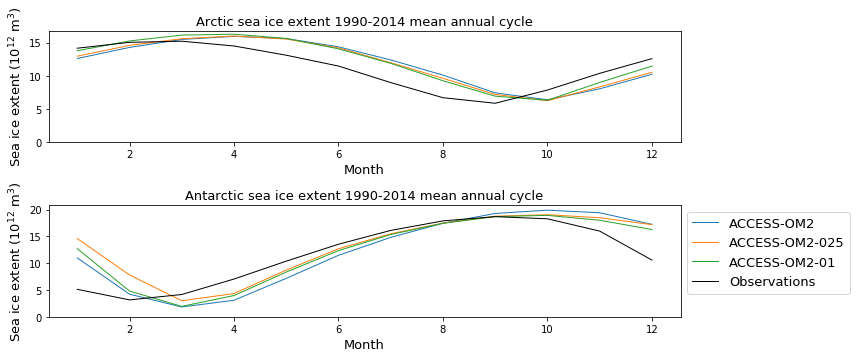

In [118]:
# seasonal cycle of extent for all models
plt.figure(1,(12,5))
for c, ekey in enumerate(ice_data.keys()):
    plt.subplot(2,1,1)
    v = ice_data[ekey]['NH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

    plt.subplot(2,1,2)
    v = ice_data[ekey]['SH_extent']/1e12
    v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
    plt.plot(v['month'],v, color='C'+str(c), linewidth=1, label=ice_data[ekey]['desc'])

plt.subplot(2,1,1)
v = NH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,2)
v = SH_obs.extent/1e12
v = v.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)
plt.plot(v['month'],v, color='k', linewidth=1, label='Observations')

plt.subplot(2,1,1)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^2$)',font)
plt.title('Arctic sea ice extent '+yearrange+' mean annual cycle',font)
plt.subplot(2,1,2)
plt.ylim(ymin=0)
plt.xlabel('Month',font)
plt.ylabel(r'Sea ice extent (10$^{12}$ m$^23$)',font)
plt.title('Antarctic sea ice extent '+yearrange+' mean annual cycle',font)
plt.legend(prop=font,loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

savefigure('ice_extent_seasonal_clim')`

## Month-by-month concentration comparisons
NB: pandas/xarray bug: can't handle Sept 1995 or Jan 1985 (hash failure of some sort)
```
Timestamp('1995-09-01 00:00:00')
```

In [19]:
def get_obs(obsFileList, years, months, variable='goddard_merged_seaice_conc_monthly'): # seaice_conc_monthly_cdr'): # 
    '''
    Return a dataarray from the nc files in obsFileList.
    Based on get_nc_variable.
                                TODO: fix bug: land mask has white outline - -----------
    '''
    dataarrays = []
    for year in tqdm_notebook(years, leave=False, desc='year'):
        for month in tqdm_notebook(months, leave=False, desc='month'):
            obs_fname = [IceFile for IceFile in obsFileList if IceFile[-16:-10]==str(year)+str(month).zfill(2)][0]
            dataarray = xr.open_dataset(obs_fname,
                                        decode_times=False,
                                        autoclose=True)[variable]
            dataarrays.append(dataarray)
    dataarray = xr.concat(dataarrays, dim='time', coords='all')
    if 'time' in dataarray.coords:
        time_units = dataarray.time.units
        decoded_time = xr.conventions.times.decode_cf_datetime(dataarray.time, time_units)
        dataarray.coords['time'] = ('time', decoded_time,
                                    {'long_name': 'time', 'decoded_using': time_units }
                                   )
    # replace values outside valid range with nan
    dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=0,
                                                      dataarray<=1), 
                                np.nan)
# this doesn't work because valid_range is wrong...
#     dataarray = dataarray.where(xr.ufuncs.logical_and(dataarray>=dataarray.valid_range[0],
#                                                       dataarray<=dataarray.valid_range[1]), 
#                                 np.nan)
    return dataarray

In [20]:
years = range(firstyear, lastyear+1)
months = range(1,13)

CN_obs_NH = get_obs(obsNHFileList, years, months)
CN_obs_SH = get_obs(obsSHFileList, years, months)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/conventions.py:362: SerializationWarning: variable 'melt_onset_day_seaice_conc_monthly_cdr' has multiple fill values {-1, 65535}, decoding all values to NaN.
  stack_char_dim=stack_char_dim)


In [21]:
CN_obs_NH['longitude'].max()

<xarray.DataArray 'longitude' ()>
array(179.813975)

In [22]:
CN_obs_NH_monthly_mean = CN_obs_NH.groupby('time.month').mean('time', skipna=True)
CN_obs_SH_monthly_mean = CN_obs_SH.groupby('time.month').mean('time', skipna=True)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [23]:
levels = np.arange(0,1.01,.02)
cmap_gamma = 4. # exponent for power-law stretch of colormap
cbar_ticks = [ f**cmap_gamma for f in [0,.5,.6,.7,.8,.85,.9,.95,.98,1] ]
clevel = 0.15

In [24]:
def plot_NH_conc_model(m, x, y, model, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model[NLAT_half:,:]**cmap_gamma,levels=levels,cmap=cm.cm.ice)
    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    cs = m.contour(x,y,model[NLAT_half:,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center right') #, bbox_to_anchor=(1, 1))

In [25]:
def plot_SH_conc_model(m, x, y, model, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(x,y,model[:NLAT_half,:]**cmap_gamma,levels=levels,cmap=cm.cm.ice)
    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    cs = m.contour(x,y,model[:NLAT_half,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center') #, bbox_to_anchor=(1, 1))

In [26]:
def plot_NH_conc_obs(m, x, y, model, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cm.cm.ice)
    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    m.contour(x,y,model[NLAT_half:,:],[clevel],colors='g',linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[False,True,False,True],size=tick_font,color='white',linewidth=0.5)

In [27]:
def plot_SH_conc_obs(m, x, y, model, xobs, yobs, obs):
    model = exptdata.joinseams(model)
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    ctr = m.contourf(xobs,yobs,obs**cmap_gamma,levels=levels,cmap=cm.cm.ice)
    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    m.contour(x,y,model[:NLAT_half,:],[clevel],colors='g',linewidths=1)

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[False,True,False,True],size=tick_font,color='white',linewidth=0.5)

In [28]:
# Arctic ice concentration monthly climatology
def plot_NH_conc_monthly_mean(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_concentration_map_NH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_NH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plt.subplot(1,2,1)
            plot_NH_conc_model(m, x, y, model, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)

            # plot observations
            ax = plt.subplot(1,2,2)
            plot_NH_conc_obs(m, x, y, model, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, observed', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.945, .5), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='center')

            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [29]:
# Antarctic ice concentration monthly climatology
def plot_SH_conc_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
    xobs,yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        outname = ekey+'_concentration_map_SH_'+yearrange+'_'+str(month).zfill(2)+'_mean'
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            try:
                model = aice_m_monthly_mean.sel(month=mi+1)
                obs = CN_obs_SH_monthly_mean.sel(month=mi+1)
            except:
                print('ERROR: could not open files')
                continue
            plt.figure(4,(12,7))

            # plot model
            plt.subplot(1,2,1)
            plot_SH_conc_model(m, x, y, model, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)

            # plot observations
            ax = plt.subplot(1,2,2)
            plot_SH_conc_obs(m, x, y, model, xobs, yobs, obs)
            plt.title(calendar.month_name[month]+' '+yearrange+' mean, observed', font) #, y=1.03)
            ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                xy=(.73, .55), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='center')


            plt.tight_layout()

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

            plt.close()

#         break

In [30]:
# Arctic ice concentration for each month
def plot_NH_conc_months(ekey):
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(CN_obs_NH.longitude.isel(time=1).data, CN_obs_NH.latitude.isel(time=1).data))

    for year in years:
        for month in months:
            outnamebase = ekey+'_concentration_map_NH'
            outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    model = aice_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
                    obs = CN_obs_NH.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))

                # plot model
                plt.subplot(1,2,1)
                plot_NH_conc_model(m, x, y, model, xobs, yobs, obs)
                plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)

                # plot observations
                ax = plt.subplot(1,2,2)
                plot_NH_conc_obs(m, x, y, model, xobs, yobs, obs)
                plt.title(calendar.month_name[month]+' '+str(year)+', observed', font) #, y=1.03)
                ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                    xy=(.945, .5), xycoords='figure fraction',
                    horizontalalignment='right', verticalalignment='center')

                plt.tight_layout()

    #             savefigure(outname)
                plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

                plt.close()

#             break
#         break

In [31]:
# Antarctic ice concentration for each month
def plot_SH_conc_months(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
    xobs,yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))

    for year in years:
        for month in months:
            outnamebase = ekey+'_concentration_map_SH'
            outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    model = aice_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
                    obs = CN_obs_SH.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))

                # plot model
                plt.subplot(1,2,1)
                plot_SH_conc_model(m, x, y, model, xobs, yobs, obs)
                plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)

                # plot observations
                ax = plt.subplot(1,2,2)
                plot_SH_conc_obs(m, x, y, model, xobs, yobs, obs)
                plt.title(calendar.month_name[month]+' '+str(year)+', observed', font) #, y=1.03)
                ax.annotate('NOAA G02202 V3\nPassive microwave\nGoddard merged\nmonthly data',
                    xy=(.73, .55), xycoords='figure fraction',
                    horizontalalignment='center', verticalalignment='center')

                plt.tight_layout()

    #             savefigure(outname)
                plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

                plt.close()

#             break
#         break

In [ ]:
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
    plot_NH_conc_monthly_mean(ekey)
    plot_SH_conc_monthly_mean(ekey)

In [32]:
for ekey in exptdata.exptdict.keys():
    print(ekey)
    loaddata(ekey)
    plot_NH_conc_months(ekey)
    plot_SH_conc_months(ekey)

#     break

1deg
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_vicen_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_01 (file exists)
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_02 (file exists)
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_03 (file exists)
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_04 (file exists)
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_05 (file exists)
Skipping NOSYNC/1deg_concentration_map_NH/1deg_concentration_map_NH_1990_06 (file exists)
Skipping NOSYNC/1deg_concentration_map_

Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_01 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_02 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_03 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_04 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_05 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_06 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_07 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_08 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_09 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_10 (file exists)
Skipping NOSYNC/1deg_concentration_map_SH/1deg_concentration_map_SH_1990_11 (file exists)
Skipping N

Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_iceh.????-??.nc_aice_m_-500_days-since-1718-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_025deg_jra55v13_iaf_gmredi_iceh.????-??.nc_hi_m_-500_days-since-1718-01-01_None_False.pkl
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_01 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_02 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_03 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_04 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_05 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_06 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map_NH_1990_07 (file exists)
Skipping NOSYNC/025deg_concentration_map_NH/025deg_concentration_map

Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_01 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_02 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_03 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_04 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_05 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_06 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_07 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_08 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_09 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentration_map_SH_1990_10 (file exists)
Skipping NOSYNC/025deg_concentration_map_SH/025deg_concentra

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_aice_m_-500_None_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hi_m_-500_None_None_False.pkl
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_01 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_02 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_03 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_04 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_05 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_06 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_07 (file exists)
Skipping NOSYNC/01deg_concentration_map_NH/01deg_concentration_map_NH_1990_08 (file exists)
Skipping NOSYNC/01deg_concentration_map_

Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_01 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_02 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_03 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_04 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_05 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_06 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_07 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_08 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_09 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_10 (file exists)
Skipping NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_1990_11 (f

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2006_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2007_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2008_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2009_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2010_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2011_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2012_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2013_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_01


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_02


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_03


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_04


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_05


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_06


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_07


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_08


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_09


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_10


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_11


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

Doing NOSYNC/01deg_concentration_map_SH/01deg_concentration_map_SH_2014_12


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instea

## Monthly thickness climatology by category

TODO: use fixed contour levels for each category and more contour levels

In [27]:
def plot_SH_thickness(m, x, y, model, model_aice, xobs, yobs, obs, c):
    model = exptdata.joinseams(model)
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
#     ctr = m.contourf(x,y,model[:NLAT_half,:],levels=50,cmap=cm.cm.ice)

    ctr = m.contourf(x,y,model[:NLAT_half,:],cmap=cm.cm.ice)

    ctr.cmap.set_over(color='w', alpha=None)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice thickness in category '+str(c+1)+' (m)',size=tick_font)
#     cbar.set_ticks(cbar_ticks)
#     cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
#     cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
#     plt.setp(cbar_labels,fontsize=tick_font)
    cs = m.contour(x,y,model_aice[:NLAT_half,:],[clevel],colors='g',linewidths=1)
    cs.collections[0].set_label('model '+str(int(clevel*100))+'%')
    cs = m.contour(xobs,yobs,obs,[clevel],colors='r',linewidths=1)
    cs.collections[0].set_label('obs '+str(int(clevel*100))+'%')

    parallels = np.arange(-80.,81,10.)
    m.drawparallels(parallels,color='white',linewidth=0.5)
    meridians = np.arange(0.,351.,30.)
    m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)
    plt.legend(prop={'size':11},loc='center') #, bbox_to_anchor=(1, 1))

In [28]:
# Antarctic ice thickness monthly climatology
def plot_SH_thickness_monthly_mean(ekey):
    m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
    x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
    xobs,yobs = m(*(CN_obs_SH.longitude.isel(time=1).data, CN_obs_SH.latitude.isel(time=1).data))

    for mi, month in enumerate(months):
        for c in range(len(vicen_m_monthly_mean['nc'])):
            outname = ekey+'_thickness_map_SH_cat'+str(c+1)+'_'+yearrange+'_'+str(month).zfill(2)+'_mean'
            if os.path.exists(os.path.join(figdir, outname+'.png')):
                print('Skipping ' + outname + ' (file exists)')
            else:
                print('Doing ' + outname)
                try:
                    model = vicen_m_monthly_mean.sel(month=mi+1).sel(nc=c)
                    model_aice = aice_m_monthly_mean.sel(month=mi+1)
                    obs = CN_obs_SH_monthly_mean.sel(month=mi+1)
                except:
                    print('ERROR: could not open files')
                    continue
                plt.figure(4,(12,7))

                # plot model
    #             plt.subplot(1,2,1)
                plot_SH_thickness(m, x, y, model, model_aice, xobs, yobs, obs, c)
                plt.title(calendar.month_name[month]+' '+yearrange+' mean, ' + exptdata.exptdict[ekey]['desc'], font)


                plt.tight_layout()

    #             savefigure(outname)
                plt.savefig(outname+'.png',dpi=200, bbox_inches="tight")

                plt.close()
#             break

#         break

In [29]:
# cmap_gamma = 1.0
for ekey in exptdata.exptdict.keys():
    if ekey=='01deg':
        print(ekey)
        loaddata(ekey)
        plot_SH_thickness_monthly_mean(ekey)
    #     break

01deg
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_vicen_m_-500_None_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_aice_m_-500_None_None_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Saving cache file cache_get_nc_variable_01deg_jra55v13_iaf_iceh.????-??.nc_hi_m_-500_None_None_False.pkl
Doing 01deg_thickness_map_SH_cat1_1995-2014_01_mean


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1709: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1712: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.07/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Doing 01deg_thickness_map_SH_cat2_1995-2014_01_mean
Doing 01deg_thickness_map_SH_cat3_1995-2014_01_mean
Doing 01deg_thickness_map_SH_cat4_1995-2014_01_mean
Doing 01deg_thickness_map_SH_cat5_1995-2014_01_mean
Doing 01deg_thickness_map_SH_cat1_1995-2014_02_mean
Doing 01deg_thickness_map_SH_cat2_1995-2014_02_mean
Doing 01deg_thickness_map_SH_cat3_1995-2014_02_mean
Doing 01deg_thickness_map_SH_cat4_1995-2014_02_mean
Doing 01deg_thickness_map_SH_cat5_1995-2014_02_mean
Doing 01deg_thickness_map_SH_cat1_1995-2014_03_mean
Doing 01deg_thickness_map_SH_cat2_1995-2014_03_mean
Doing 01deg_thickness_map_SH_cat3_1995-2014_03_mean
Doing 01deg_thickness_map_SH_cat4_1995-2014_03_mean
Doing 01deg_thickness_map_SH_cat5_1995-2014_03_mean
Doing 01deg_thickness_map_SH_cat1_1995-2014_04_mean
Doing 01deg_thickness_map_SH_cat2_1995-2014_04_mean
Doing 01deg_thickness_map_SH_cat3_1995-2014_04_mean
Doing 01deg_thickness_map_SH_cat4_1995-2014_04_mean
Doing 01deg_thickness_map_SH_cat5_1995-2014_04_mean
Doing 01deg_

In [ ]:
STOPHERE

In [ ]:
aice_m.sel(time=pd.to_datetime('198501', format='%Y%m'))  # BUG: some sort of hashing problem??

# Thickness maps
TODO: redo these as above, and plot for all resolutions

In [ ]:
levels = np.arange(0,5.01,0.1)
cmap_gamma = 1 # exponent for power-law stretch of colormap
cbar_ticks = np.arange(0,5.01,1)
cbar_ticks = [ f**cmap_gamma for f in np.arange(0,5.01,1) ]

In [ ]:
# Arctic ice thickness

m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_NH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_NH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            # plot model
#             plt.subplot(1,2,1)
            m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[NLAT_half:,:]**cmap_gamma,levels=levels,cmap=cm.cm.ice, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[NLAT_half:,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
# Antarctic ice thickness

m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))

for yi, year in enumerate(years):
    for mi, month in enumerate(months):
        outnamebase = ekey+'_thickness_map_SH'
        outname = NOSYNC+outnamebase+'/'+outnamebase+'_'+str(year)+'_'+str(month).zfill(2)
        if os.path.exists(os.path.join(figdir, outname+'.png')):
            print('Skipping ' + outname + ' (file exists)')
        else:
            print('Doing ' + outname)
            model = hi_m.sel(time=pd.to_datetime(str(year)+str(month).zfill(2), format='%Y%m'))
            obs = CN_obs_SH[yi*len(months) + mi]
            plt.figure(4,(12,7))

            m = Basemap(projection='spstere',boundinglat=-54,lon_0=180,resolution='l') #,round='True')
            m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
            ctr = m.contourf(x,y,model[:NLAT_half,:]**cmap_gamma,levels=levels,cmap=cm.cm.ice, extend='max')
            ctr.cmap.set_over(color='w', alpha=None)
            plt.title(calendar.month_name[month]+' '+str(year)+', ' + exptdata.exptdict[ekey]['desc'], font)
            cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
            cbar.set_label('Ice  thickness (m)',size=tick_font)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels([str(f**(1./cmap_gamma)) for f in cbar_ticks])
            cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
            plt.setp(cbar_labels,fontsize=tick_font)
            m.contour(x,y,model[:NLAT_half,:],[0.3],colors='g',linewidth=0.5)
            m.contour(xobs,yobs,obs,[0.3],colors='r',linewidth=0.5)
            
            parallels = np.arange(-80.,81,10.)
            # labels = [left,right,top,bottom]
            m.drawparallels(parallels,color='white',linewidth=0.5)#,labels=[False,True,True,False],size=tick_font)
            meridians = np.arange(0.,351.,30.)
            m.drawmeridians(meridians,labels=[True,False,False,True],size=tick_font,color='white',linewidth=0.5)

#             savefigure(outname)
            plt.savefig(outname+'.png',dpi=150, bbox_inches="tight")

            plt.close()

#         break
#     break

In [ ]:
STOPHERE
# old stuff below. try to redo this above using approach in surface_current.ipynb

In [134]:
aice_m[:NLAT_half,:]

<xarray.DataArray 'aice_m' (time: 150, nj: 300, ni: 360)>
dask.array<shape=(150, 300, 360), dtype=float32, chunksize=(1, 300, 360)>
Coordinates:
    ULAT     (time, nj, ni) float32 dask.array<shape=(150, 300, 360), chunksize=(1, 300, 360)>
    TLON     (time, nj, ni) float32 dask.array<shape=(150, 300, 360), chunksize=(1, 300, 360)>
  * time     (time) datetime64[ns] 1976-06-01 1976-07-01 ... 1988-11-01
    TLAT     (time, nj, ni) float32 dask.array<shape=(150, 300, 360), chunksize=(1, 300, 360)>
    ULON     (time, nj, ni) float32 dask.array<shape=(150, 300, 360), chunksize=(1, 300, 360)>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [ ]:
aice_m_monthly_mean = aice_m.sel(time=slice(tstart,tend)).groupby('time.month').mean('time', skipna=True)



NH_climatology = aice_m_monthly_mean

ice_area_north_climatology = np.zeros(12)

ice_area_south_climatology = np.zeros(12)

In [ ]:
# climatological seasonal cycle of annual sea ice area - take monthly averages of 
# concentration, then sum area where CN > 15%

ice_area_south = []
ice_area_north = []

for IceFile in tqdm_notebook(dataFileList[-n_files:], leave=False):
    ncFile = nc.Dataset(IceFile,'r')
    CN = ncFile.variables['aice_m']
    for month in range(CN.shape[0]):
        area_field = np.ma.where(CN[month,...]>0.15,area_t,0)
        ice_area_south = np.append(ice_area_south,np.sum(area_field[:NLAT_half,...]))
        ice_area_north = np.append(ice_area_north,np.sum(area_field[NLAT_half:,...]))

In [ ]:
# do annual averages:
ice_area_south_climatology = np.zeros(12)
ice_area_north_climatology = np.zeros(12)
for month in range(12):
    ice_area_south_climatology[month] = np.mean(ice_area_south[month::12])
    ice_area_north_climatology[month] = np.mean(ice_area_north[month::12])
# sort months from Jan -> Dec (for model we don't necessarily start with Jan data)
time = ncFile.variables['time']
time_convert = nc.num2date(time[-1],time.units,time.calendar)
last_month = time_convert.month
last_year = time_convert.year
ice_area_south_climatology = np.roll(ice_area_south_climatology,last_month-1)
ice_area_north_climatology = np.roll(ice_area_north_climatology,last_month-1)

ncFile.close()

# Stop here with deliberate error

In [ ]:
STOPHERE

## Climatologies

In [ ]:
############################################
####### obs climatology:
# for obs just use years 1988-1997, because concentration not available before then (*WRONG!*) and 
# climate change after then

# conc_firstyear = 1988
# conc_lastyear  = 1997

conc_firstyear = tclimstart.year
conc_lastyear = tclimend.year-1

# NH All:
# CN_obs_NH = [[] for _ in range(12)]  # list keeps months separate
CN_obs_NH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):  # NB: mo counts from 0
    # length of climatology:
    obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
#     obs_list = [IceFile for IceFile in obsNHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
#         IceFile.find('nh_f')>0 and float(IceFile[-16:-12])>1983 and \
#         float(IceFile[-16:-12])<1986)] 

    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile, 'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_NH[mo] is None:
            CN_obs_NH[mo] = tmp
        else:
            CN_obs_NH[mo] = CN_obs_NH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]<0,CN_obs_NH[mo]) / n_yrs
    CN_obs_NH[mo] = np.ma.masked_where(CN_obs_NH[mo]>2,CN_obs_NH[mo])
obs_lat_NH = ncFile.variables['latitude'][...]
obs_lon_NH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
obsNHFileList

In [ ]:
# SH All:
CN_obs_SH = [None]*12
for mo in tqdm_notebook(range(12), leave=False, desc='month'):
    # length of climatology:
    obs_list = [IceFile for IceFile in obsSHFileList if (IceFile.find(str(mo+1).zfill(2)+'_v0')>0 and 
        IceFile.find('sh_f')>0 and float(IceFile[-16:-12])>=conc_firstyear and \
        float(IceFile[-16:-12])<=conc_lastyear)] 
    n_yrs = len(obs_list)
    for IceFile in tqdm_notebook(obs_list, leave=False, desc='year'):
    #     print('opening '+IceFile)
        ncFile = nc.Dataset(IceFile,'r')
        tmp = ncFile.variables['seaice_conc_monthly_cdr'][0,...]
        if CN_obs_SH[mo] is None:
            CN_obs_SH[mo] = tmp
        else:
            CN_obs_SH[mo] = CN_obs_SH[mo] + tmp
    # divide by n_yrs and mask land / arctic pole hole:
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]<0,CN_obs_SH[mo]) / n_yrs
    CN_obs_SH[mo] = np.ma.masked_where(CN_obs_SH[mo]>2,CN_obs_SH[mo])
obs_lat_SH = ncFile.variables['latitude'][...]
obs_lon_SH = ncFile.variables['longitude'][...]
ncFile.close()

In [ ]:
# monthly ice concentration climatologies

CN_Feb = 0
CN_Mar = 0
CN_Sep = 0

CN_Sep_years = [[] for _ in range(n_years)]

# Feb (Antarctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-02.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Feb = CN_Feb + ncFile.variables['aice_m'][0,:NLAT_half,:]

# March (Arctic only)
for IceFile in [f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-03.nc')]:
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
    CN_Mar = CN_Mar + ncFile.variables['aice_m'][0,NLAT_half:,:]

# Sep (both)
for n,IceFile in enumerate([f for f in dataFileList[firstfile:firstfile+n_files] if f.endswith('-09.nc')]):
#     print('opening '+IceFile)
    ncFile = nc.Dataset(IceFile,'r')
#     CN_Sep_years[n] = np.append(CN_Sep_years, ncFile.variables['aice_m'][0,:,:])
    CN_Sep_years[n] = ncFile.variables['aice_m'][0,:,:]
    CN_Sep = CN_Sep + CN_Sep_years[n]
    CN_Sep_years[n] = np.ma.masked_where(land_mask==1,CN_Sep_years[n])

# divide by n_years and mask:
CN_Feb = np.ma.masked_where(land_mask[:NLAT_half,:]==1,CN_Feb / n_years)
CN_Mar = np.ma.masked_where(land_mask[NLAT_half:,:]==1,CN_Mar / n_years)
CN_Sep = np.ma.masked_where(land_mask==1,CN_Sep / n_years)
ncFile.close()

In [ ]:
levels = np.arange(0,1.01,.01)
font = {'size':13}
tick_font=13

### Arctic model concentration maps, Sept and March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Mar_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')


plt.tight_layout()

# savefigure('Arctic_concentration_map')

### Arctic model and obs concentration maps, Sept

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Sep[NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
# m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')


plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[NLAT_half:,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Sep')

In [ ]:
plt.figure(4,(12,7*n_years))
plt.clf()

# TODO: check that the CN_Sep_years list elements are not identical

for n in tqdm_notebook(range(n_years), leave=False):
    year = int(int(total_years)-n_years+n+1)
    plt.subplot(n_years,1,n+1)
    m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
    m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
    x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
    xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
    ctr = m.contourf(x,y,CN_Sep_years[n][NLAT_half:,:],levels=levels,cmap='viridis', extend='max')
    ctr.cmap.set_over(color='w', alpha=None)
    # plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
    # 	str(last_year),font,y=1.03)
    plt.title('September, year '+str(year),font,y=1.03)
    cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
    cbar.set_label('Ice concentration',size=tick_font)
    cbar.set_ticks([0,.2,.4,.6,.8,1])
    cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
    plt.setp(cbar_labels,fontsize=tick_font)
    #m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
    m.contour(x,y,CN_Sep_years[n][NLAT_half:,:],[0.3],colors='w')
    # obs:
#     m.contour(xobs,yobs,CN_obs_Sep_NH,[0.3],colors='r')
    m.contour(xobs,yobs,CN_obs_NH[9-1],[0.3],colors='r')

### Arctic model and obs concentration maps, March

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[NLAT_half:,:],lat_t[NLAT_half:,:]))
xobs,yobs = m(*(obs_lon_NH,obs_lat_NH))
ctr = m.contourf(x,y,CN_Mar,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='npstere',boundinglat=48,lon_0=0,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_NH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('March max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('March max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[NLAT_half:,:],[0,1],colors='w')
m.contour(x,y,CN_Mar,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_NH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Arctic_concentration_map_Mar')

### Antarctic model and obs concentration maps

In [ ]:
plt.figure(3,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[2-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-50,lon_0=180,resolution='l',round='True')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='w', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map')

### Antarctic model and obs concentration maps, Feb

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Feb,levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[3-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('February min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('February min, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Feb,[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[3-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Feb')

### Antarctic model and obs concentration maps, Sep

In [ ]:
plt.figure(4,(12,7))
plt.clf()

plt.subplot(1,2,1)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
x,y = m(*(lon_t[:NLAT_half,:],lat_t[:NLAT_half,:]))
xobs,yobs = m(*(obs_lon_SH,obs_lat_SH))
ctr = m.contourf(x,y,CN_Sep[:NLAT_half,:],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September min, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, model',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.subplot(1,2,2)
m = Basemap(projection ='spstere',boundinglat=-54,lon_0=180,resolution='l')
m.drawmapboundary(fill_color='gray') # background color - for non-ocean areas
ctr = m.contourf(xobs,yobs,CN_obs_SH[9-1],levels=levels,cmap='viridis', extend='max')
ctr.cmap.set_over(color='y', alpha=None)
# plt.title('September max, yrs '+str(last_year-(n_years-1))+'-'+
# 	str(last_year),font,y=1.03)
plt.title('September max, obs',font,y=1.03)
cbar = m.colorbar(ctr, location = 'bottom', pad = "6%")
cbar.set_label('Ice concentration',size=tick_font)
cbar.set_ticks([0,.2,.4,.6,.8,1])
cbar_labels=plt.getp(cbar.ax.axes,'xticklabels')
plt.setp(cbar_labels,fontsize=tick_font)
#m.contour(x,y,land_mask[:NLAT_half,:],[0,1],colors='w')
m.contour(x,y,CN_Sep[:NLAT_half,:],[0.3],colors='w')
# obs:
m.contour(xobs,yobs,CN_obs_SH[9-1],[0.3],colors='r')

plt.tight_layout()

# savefigure('Antarctic_concentration_map_Sep')

## Thickness maps